# Fraud Detection Model

This notebook loads the Rotterdam benefits fraud investigation data, preprocesses it, and trains a Decision Tree model to predict the `checked` status.

In [1]:
%pip install pandas numpy scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
print(sys.executable)


/Users/dimanavihrenova/Desktop/testing-ai/.venv/bin/python


## 1. Data Loading

In [3]:
# Load the dataset
df = pd.read_csv('../data/investigation_train_large_checked.csv')

# Display basic info and first few rows
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130000 entries, 0 to 129999
Columns: 318 entries, adres_aantal_brp_adres to checked
dtypes: bool(1), float64(2), int64(315)
memory usage: 314.5 MB
None


,adres_aantal_brp_adres,adres_aantal_verschillende_wijken,adres_aantal_verzendadres,adres_aantal_woonadres_handmatig,adres_dagen_op_adres,adres_recentst_onderdeel_rdam,adres_recentste_buurt_groot_ijsselmonde,adres_recentste_buurt_nieuwe_westen,adres_recentste_buurt_other,adres_recentste_buurt_oude_noorden,...,typering_hist_ind,typering_hist_sector_zorg,typering_ind,typering_indicatie_geheime_gegevens,typering_other,typering_transport__logistiek___tuinbouw,typering_zorg__schoonmaak___welzijn,Ja,Nee,checked
0,1,1,0,0,23240,1,0,0,0,0,...,1,0,0,0,0,0,0,0.617698,0.382302,False
1,4,2,1,1,1971,1,0,0,1,0,...,1,0,1,0,1,0,0,0.602167,0.397833,False
2,6,4,2,1,7247,0,0,0,1,0,...,1,0,1,0,0,0,0,0.512377,0.487623,False
3,3,2,0,1,8060,1,0,0,1,0,...,1,0,0,0,0,0,0,0.717796,0.282204,True
4,3,2,0,0,18705,1,0,0,0,0,...,1,0,1,0,0,0,0,0.705484,0.294516,True


## 2. Preprocessing

In [4]:
# Drop 'Ja' and 'Nee' columns if they exist (potential data leakage)
cols_to_drop = [col for col in ['Ja', 'Nee'] if col in df.columns]
if cols_to_drop:
    df = df.drop(columns=cols_to_drop)
    print(f"Dropped columns: {cols_to_drop}")

# Convert 'checked' target column to integer (0/1)
if df['checked'].dtype == 'bool' or df['checked'].dtype == 'object':
    df['checked'] = df['checked'].astype(int)

print("Target distribution:")
print(df['checked'].value_counts())

Dropped columns: ['Ja', 'Nee']
Target distribution:
checked
0    110496
1     19504
Name: count, dtype: int64


## 3. Modeling

In [5]:
# Check Class Balance
print("Class distribution:")
print(df['checked'].value_counts(normalize=True))

Class distribution:
checked
0    0.849969
1    0.150031
Name: proportion, dtype: float64


In [6]:
# Separate features and target
X = df.drop(columns=['checked'])
y = df['checked']

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (104000, 315)
Testing set shape: (26000, 315)


In [15]:
X_train = np.nan_to_num(X_train, nan=0, posinf=1e9, neginf=-1e9)
X_test  = np.nan_to_num(X_test, nan=0, posinf=1e9, neginf=-1e9)

# Scale data so oversampling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)
#  SMOTE oversampling to the training data only
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)


In [18]:
# Initialize and train Random Forest Classifier
# class_weight='balanced' handles the class imbalance
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced_subsample', n_jobs=-1)
clf.fit(X_res, y_res)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## 4. Evaluation

Accuracy: 0.9060
ROC AUC Score: 0.7931

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95     22029
           1       0.72      0.63      0.67      3971

    accuracy                           0.91     26000
   macro avg       0.83      0.79      0.81     26000
weighted avg       0.90      0.91      0.90     26000



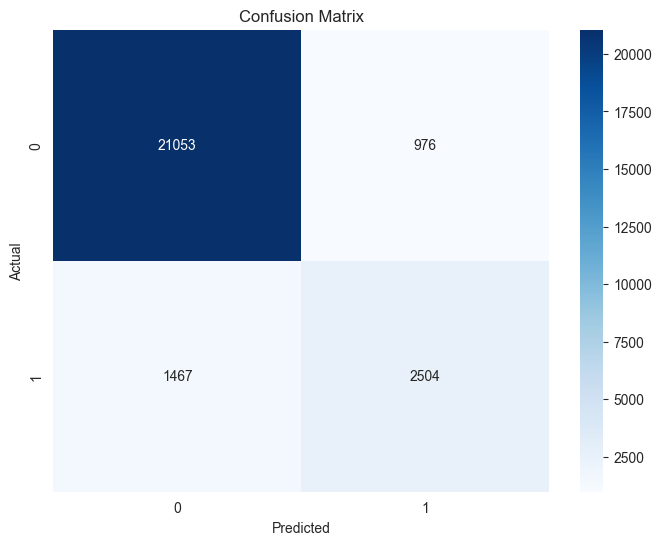

In [30]:
# Predict on test set
y_proba = clf.predict_proba(X_test)[:, 1]
y_pred = (y_proba > 0.63).astype(int)

# Calculate Metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Classification Report (Focus on Precision/Recall for Class 1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

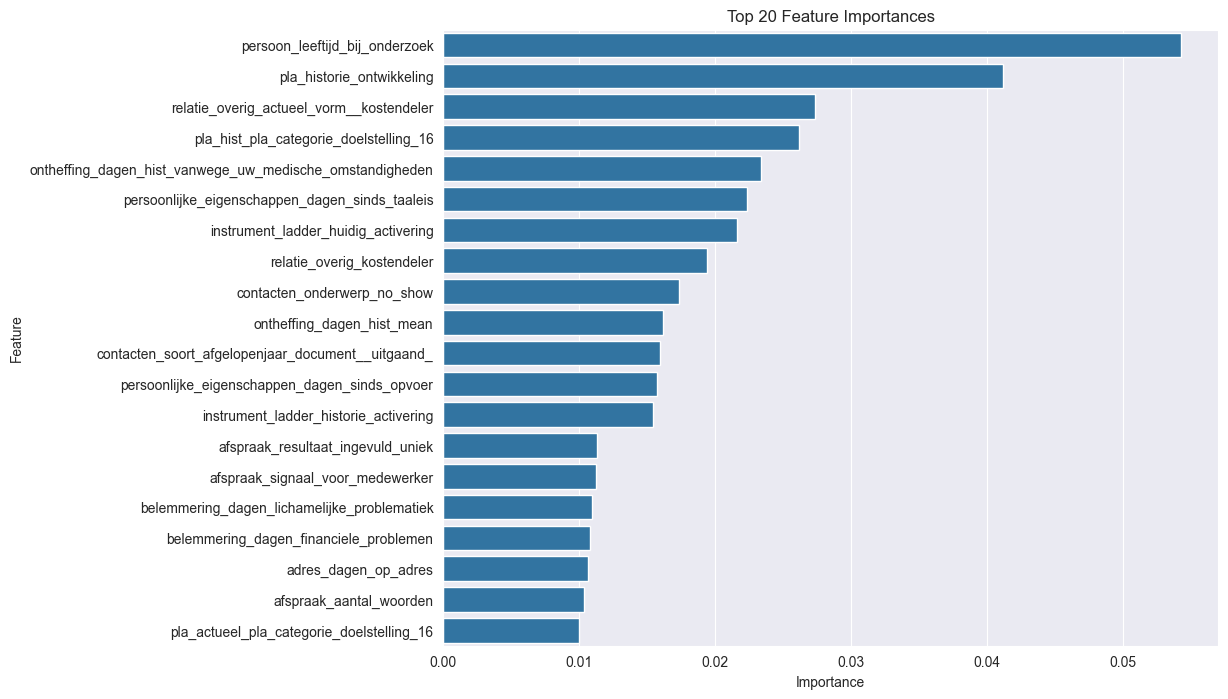

In [9]:
# Feature Importance
importances = clf.feature_importances_
feature_names = X.columns
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df)
plt.title('Top 20 Feature Importances')
plt.show()